# PySpark Project

The restaurant has the following data to solve simple questions about its clients, trends, money spend and favorite items of the menu.

![data structure](pizza_danny.png)

## Ensure we have everything in place

Before start working with spark, let's confirm if we have our SparkSession and SparkContext properly set.

In [2]:
import pyspark
sc = pyspark.SparkContext('local[*]')
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

# Create my_spark
spark = SparkSession.builder.appName('analyze_data').getOrCreate()

22/10/01 15:35:03 WARN Utils: Your hostname, andresmesad.local resolves to a loopback address: 127.0.0.1; using 192.168.80.25 instead (on interface en0)
22/10/01 15:35:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/01 15:35:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
print(f"We are running Spark: {sc.version}")

We are running Spark: 3.3.0


In [4]:
print(f"We are using Python {sc.pythonVer}")

We are using Python 3.8


### Import all neccesary libraries

In [5]:
# Import sql types to define our schemas
from pyspark.sql.types import *
# Import all SQL functions as F to clean and transform data
import pyspark.sql.functions as F
# To do window functions
from pyspark.sql.window import Window

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's list the neccesary files there

In [9]:
!ls -l ./data

total 24
-rw-r--r--  1 andresmesad  staff   48  1 Oct 15:37 members.csv
-rw-r--r--  1 andresmesad  staff   63  1 Oct 15:37 menu.csv
-rw-r--r--  1 andresmesad  staff  259  1 Oct 15:37 sales.csv


## Create the PySpark DataFrames to Analyze the data

Now we now that we have the data in the DataBricks FileSystem, now let's create the dataframes to analyze the data later on.

In [10]:
files = {
    'menu': './data/menu.csv',
    'members': './data/members.csv',
    'sales':'./data/sales.csv'
}

### Create the menu_df

In [11]:
menu_schema = StructType([
    StructField('product_id', IntegerType(), False),
    StructField('product_name', StringType(), False),
    StructField('price', IntegerType(), False),
])

In [12]:
menu_df = (
    spark
    .read
    .format('csv')
    .options(header=True, inferschema=True)
    .schema(menu_schema)
    .load(files['menu'])
)

In [13]:
menu_df.show()

+----------+------------+-----+
|product_id|product_name|price|
+----------+------------+-----+
|         1|       sushi|   10|
|         2|       curry|   15|
|         3|       ramen|   12|
+----------+------------+-----+



In [14]:
menu_df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- price: integer (nullable = true)



### Create the sales_df

In [15]:
sales_schema = StructType([
    StructField('customer_id', StringType(), False),
    StructField('order_date', DateType(), False),
    StructField('product_id', IntegerType(), False),
])

In [16]:
sales_df = (
    spark
    .read
    .format('csv')
    .options(header=True)
    .schema(sales_schema)
    .load(files['sales'])
)

In [17]:
sales_df.show()

+-----------+----------+----------+
|customer_id|order_date|product_id|
+-----------+----------+----------+
|          A|2021-01-01|         1|
|          A|2021-01-01|         2|
|          A|2021-01-07|         2|
|          A|2021-01-10|         3|
|          A|2021-01-11|         3|
|          A|2021-01-11|         3|
|          B|2021-01-01|         2|
|          B|2021-01-02|         2|
|          B|2021-01-04|         1|
|          B|2021-01-11|         1|
|          B|2021-01-16|         3|
|          B|2021-02-01|         3|
|          C|2021-01-01|         3|
|          C|2021-01-01|         3|
|          C|2021-01-07|         3|
+-----------+----------+----------+



In [18]:
sales_df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- order_date: date (nullable = true)
 |-- product_id: integer (nullable = true)



### Create the members_df

In [19]:
members_schema = StructType([
    StructField('customer_id', StringType(), False),
    StructField('join_date', DateType(), False),
])

In [20]:
members_df = (
    spark
    .read
    .format('csv')
    .options(header=True)
    .load(files['members'])
)

In [21]:
members_df.show()

+-----------+----------+
|customer_id| join_date|
+-----------+----------+
|          A|2021-01-07|
|          B|2021-01-09|
+-----------+----------+



In [22]:
members_df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- join_date: string (nullable = true)



### Create temp views of these Dfs to use with SQL if needed

In [23]:
sales_df.createOrReplaceTempView('sales')
members_df.createOrReplaceTempView('members')
menu_df.createOrReplaceTempView('menu')

## Data Analysis

The data, as we saw above, is pretty clean, so we don't to perform transformations to clean those three tables. So, let's begin with the analysis to answer the following questions

**Notes**:
- We will try to solve these question with PySpark DataFrames and/or PySpark SQL

### 1.How much each customer spent in the restaurant?

In [26]:
result_1_dataframe = (
    sales_df
    .join(
        menu_df,
        sales_df.product_id ==  menu_df.product_id,
        "inner")
    .groupBy('customer_id')
    .agg(
        F.sum('price').alias('Total spend')
    )
    .orderBy(F.col('Total Spend').desc())
)

In [27]:
result_1_dataframe.show()

+-----------+-----------+
|customer_id|Total spend|
+-----------+-----------+
|          A|         76|
|          B|         74|
|          C|         36|
+-----------+-----------+



In [28]:
result_1_query = """
SELECT 
     s.customer_id
    ,SUM(m.price) AS total_spend 
FROM sales AS s
INNER JOIN menu AS m
    ON s.product_id = m.product_id
GROUP BY s.customer_id
ORDER BY total_spend DESC
"""

In [29]:
result_1_sql = (
    spark
    .sql(result_1_query)
)

In [30]:
result_1_sql.show()

+-----------+-----------+
|customer_id|total_spend|
+-----------+-----------+
|          A|         76|
|          B|         74|
|          C|         36|
+-----------+-----------+



In [31]:
result_1_pandas = result_1_sql.toPandas()

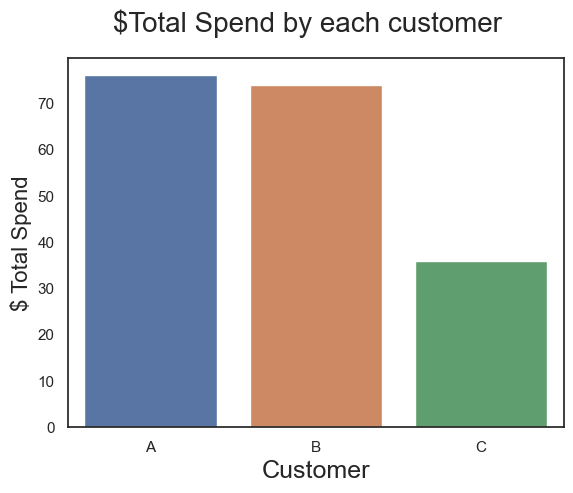

In [32]:
sns.set('notebook')
sns.set_style('white')
fig, ax = plt.subplots()

sns.barplot(
    data=result_1_pandas,
    x='customer_id',
    y='total_spend',
    ax=ax
)
fig.suptitle('$Total Spend by each customer', fontsize=20)
plt.xlabel('Customer', fontsize=18)
plt.ylabel('$ Total Spend', fontsize=16)

plt.show()

As you just saw, we could transform our `pyspark.sql.dataframe.DataFrame` into a 'pandas.core.frame.DataFrame' and use `Seaborn` and `Matplotlib` to graph our data.

Also, we could use the cool features of Databricks to visualize our data to keep it simple. I aim to hand you as many tools as possible to handle real-life scenarios.

### 2. How many days has each client visited the restaurant?

In [33]:
result_2_df = (
    sales_df
    .groupBy('customer_id')
    .agg(
        F.countDistinct('order_date').alias('visit_days')
    )
    .orderBy(F.col('visit_days').desc())
)

In [34]:
result_2_df.show()

+-----------+----------+
|customer_id|visit_days|
+-----------+----------+
|          B|         6|
|          A|         4|
|          C|         2|
+-----------+----------+



### 3. Which was the first item each client bought?

In [35]:
result_3_df = (
    sales_df
    # Join sales with menu on product_id
    .join(
        menu_df,
        menu_df.product_id == sales_df.product_id,
        'inner'
    )
    # get the row_number using partition by customer, ordering by order_Date
    .withColumn('row_number', F.row_number().over(
        Window
        .partitionBy('customer_id')
        .orderBy('order_date')
    )
               )
    # get just the first item for each customer
    .filter('row_number == 1')
    .select('customer_id', 'order_date', 'product_name')
    .withColumnRenamed('product_name', 'first_item')
    .withColumnRenamed('order_date', 'date_of_first_order')
)

In [36]:
result_3_df.show(truncate=False)

+-----------+-------------------+----------+
|customer_id|date_of_first_order|first_item|
+-----------+-------------------+----------+
|A          |2021-01-01         |sushi     |
|B          |2021-01-01         |curry     |
|C          |2021-01-01         |ramen     |
+-----------+-------------------+----------+



### 4. Which was the most popular plate in the menu? How many times did the customers buy it?

In [37]:
result_4_df = (
    sales_df
    .join(
        menu_df,
        menu_df.product_id == sales_df.product_id,
        'inner'
    )
    .groupBy('product_name')
    .agg(
        F.count('order_date').alias('product_count')
    )
    .orderBy(F.col('product_count').desc())
    .limit(1)
)

In [38]:
result_4_df.show()

+------------+-------------+
|product_name|product_count|
+------------+-------------+
|       ramen|            8|
+------------+-------------+



In [39]:
print(f"The most popular item was {result_4_df.collect()[0].product_name}. Being ordered {result_4_df.collect()[0].product_count} times.")

The most popular item was ramen. Being ordered 8 times.


### 5. Which was the most preffered plate by each customer?

In [40]:
result_5_df = (
    sales_df
    .join(
        menu_df,
        menu_df.product_id == sales_df.product_id,
        'inner'
    )
    .groupBy('customer_id', 'product_name')
    .agg(
        F.count('product_name').alias('orders')
    )
    .withColumn('plate_rank', F.rank().over(
        Window
        .partitionBy('customer_id')
        .orderBy(F.col('orders').desc())
    )
               )
    .filter('plate_rank == 1')
)

In [41]:
result_5_df.show()

+-----------+------------+------+----------+
|customer_id|product_name|orders|plate_rank|
+-----------+------------+------+----------+
|          A|       ramen|     3|         1|
|          B|       sushi|     2|         1|
|          B|       ramen|     2|         1|
|          B|       curry|     2|         1|
|          C|       ramen|     3|         1|
+-----------+------------+------+----------+



We have seen than for user `B` there is no preffered plate. We could get him sushi. ramen or curry.

### 6. What was the first item after the client became member?

In [43]:
query_question_6 = """
WITH joined_tables AS (
    SELECT 
          s.*
        , m.join_date
        , menu.product_name
    FROM sales AS s
    INNER JOIN members AS m
        ON s.customer_id = m.customer_id
        AND s.order_date >= m.join_date
    INNER JOIN menu
    ON menu.product_id = s.product_id
)
SELECT *
, ROW_NUMBER() OVER(PARTITION BY customer_id order by order_date) AS rn
FROM joined_tables
"""

In [44]:
result_6_df = (
    spark
    .sql(query_question_6)
    # Get the first buy after the join date
    .filter('rn == 1')
    .select(['customer_id', 'order_date', 'join_date', 'product_name'])
)

In [45]:
result_6_df.show()

+-----------+----------+----------+------------+
|customer_id|order_date| join_date|product_name|
+-----------+----------+----------+------------+
|          A|2021-01-07|2021-01-07|       curry|
|          B|2021-01-11|2021-01-09|       sushi|
+-----------+----------+----------+------------+



### 7. What was the item before the client became member?

In [46]:
query_question_7 = """
WITH joined_tables AS (
    SELECT 
          s.*
        , m.join_date
        , menu.product_name
    FROM sales AS s
    INNER JOIN members AS m
        ON s.customer_id = m.customer_id
        AND s.order_date < m.join_date
    INNER JOIN menu
    ON menu.product_id = s.product_id
)
, row_numbers_cte AS (
    SELECT *
    --Get the row number for each customer, but date descending
    , ROW_NUMBER() OVER(PARTITION BY customer_id order by order_date DESC) AS rn
    FROM joined_tables
)
SELECT 
      customer_id
    , order_date
    , join_date
    , product_name
FROM row_numbers_cte
WHERE
    rn = 1
"""

In [47]:
result_7_df = (
    spark
    .sql(query_question_7)
)

In [48]:
result_7_df.show()

+-----------+----------+----------+------------+
|customer_id|order_date| join_date|product_name|
+-----------+----------+----------+------------+
|          A|2021-01-01|2021-01-07|       sushi|
|          B|2021-01-04|2021-01-09|       sushi|
+-----------+----------+----------+------------+



### 8. How much money and articles did a customer buy before becoming a member?

In [49]:
# We have practiced joins enough. Let's create a Dataframe that joins all sales_df, members_df and menu_df.
all_details_query = """
SELECT
      s.customer_id
    , s.order_date
    , s.product_id
    , menu.product_name
    , menu.price
    , m.join_date
FROM sales AS s
    LEFT JOIN members AS m
        ON m.customer_id = s.customer_id
    LEFT JOIN menu
        ON menu.product_id = s.product_id
"""

In [50]:
all_details_df = (
    spark
    .sql(all_details_query)
)

In [51]:
all_details_df.createOrReplaceTempView('all_details')

In [52]:
result_8_df = (
    all_details_df
    # Filter just members
    .filter(F.col('join_date').isNotNull())
    # Filter just orders for each customer before becoming a member
    .filter('order_date < join_date')
    .groupBy('customer_id')
    .agg(
        F.count('product_id').alias('count_items'),
        F.sum('price').alias('money_spend')
    )
)

In [53]:
result_8_df.show()

+-----------+-----------+-----------+
|customer_id|count_items|money_spend|
+-----------+-----------+-----------+
|          B|          3|         40|
|          A|          2|         25|
+-----------+-----------+-----------+



### 9. If each $1 is worth of 10 points and when is sushi, you get the double points, ¿How much points each customer has?

In [54]:
query_question_9 = """
WITH points_cte AS (
    SELECT 
          *
        , CASE 
            WHEN product_name = 'sushi' THEN (price * 10 * 2)
            ELSE price * 10 END AS points 
    FROM all_details
)
SELECT
      customer_id
    , SUM(points) AS total_points
FROM points_cte
GROUP BY customer_id
ORDER BY total_points DESC;
"""

In [55]:
result_9_df = (
    spark
    .sql(query_question_9)
)

In [56]:
result_9_df.show()

+-----------+------------+
|customer_id|total_points|
+-----------+------------+
|          B|         940|
|          A|         860|
|          C|         360|
+-----------+------------+



### 10. On the first week after a client is a member (including the join date), it earns double points, not only on Sushi. How many points will customers A and B have at the end of January?

In [57]:
query_question_10 = """
WITH points_cte AS (
    SELECT 
          *
        , CASE
            --Points before joining
            WHEN order_date < join_date AND product_name = 'sushi' THEN (price * 10 * 2)
            WHEN order_date < join_date AND product_name != 'sushi' THEN (price * 10)
            --Points in the first week: double points even if it isn't sushi
            WHEN order_date BETWEEN join_date and join_date + INTERVAL '7 days' THEN (price * 10 * 2)
            --Points after
            WHEN product_name = 'sushi' THEN (price * 10 * 2)
            ELSE price * 10 END AS points 
    FROM all_details
    WHERE
        customer_id IN ('A', 'B')
        --We are interested in orders at the end of January
        AND order_date <= '2021-01-31'
)
SELECT
      customer_id
    , SUM(points) AS total_points
FROM points_cte
GROUP BY customer_id
ORDER BY total_points DESC;
"""

In [58]:
result_10_df = (
    spark
    .sql(query_question_10)
)

In [59]:
result_10_df.show()

+-----------+------------+
|customer_id|total_points|
+-----------+------------+
|          A|        1370|
|          B|         940|
+-----------+------------+

